In [165]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,explode
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import StringType
from pyspark.sql.functions import split, explode, trim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



In [166]:
dashboard_warehouse = "hdfs://namenode:8020/warehouse_layer/warehouse_track_dashboard.parquet"

spark = SparkSession.builder.appName("EDA_Dashboard").getOrCreate()

In [167]:
dashboard_df = spark.read.parquet(dashboard_warehouse)

In [168]:
dashboard_df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- explicit: string (nullable = true)
 |-- popularity_track: integer (nullable = true)
 |-- uri_track: string (nullable = true)
 |-- external_urls_tracks: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_type: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- label: string (nullable = true)
 |-- popularity_album: integer (nullable = true)
 |-- image_album: string (nullable = true)
 |-- external_urls_albums: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- popularity_artist: integer (nullable = true)
 |-- followers number: integer (nullable = true)
 |-- artist_spotify_id: string (nullable = true)
 |-- type_artist: string (nullable = true)
 |-- uri_artist: string (nullable = true)
 |-- external_urls_artists: string (nullable = true)
 |-- images_artists: string (nullable = true)
 |-- g

In [169]:
dashboard_df.show(1,vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------
 track_id              | 000PrYJCClJWZiLWmDMVnw                                           
 track_name            | Barriers                                                         
 duration_ms           | 427840                                                           
 explicit              | false                                                            
 popularity_track      | 4                                                                
 uri_track             | open.spotify.com/track/000PrYJCClJWZiLWmDMVnw                    
 external_urls_tracks  | https://open.spotify.com/track/000PrYJCClJWZiLWmDMVnw            
 album_name            | Keychains & Snowstorms – The Soft Cell Story                     
 album_type            | album                                                            
 release_date          | 2018-09-07                                                       

In [170]:
count_null = dashboard_df.filter(
    dashboard_df["energy"].isNotNull() & dashboard_df["loudness"].isNotNull()
)

In [171]:
count_null.count()

5313

In [172]:
dashboard_df.count()
dashboard_df = dashboard_df.toPandas()

<h1> KPI Overview </h1>

<h3> AVG duration (ms) </h3>

In [173]:
artist_album_df = dashboard_df[["artist_name", "album_name"]].drop_duplicates()

avg_album_per_artist = artist_album_df.groupby("artist_name").count()["album_name"].mean()
print(f"Average unique albums per artist: {avg_album_per_artist:.2f}")

Average unique albums per artist: 19.47


In [174]:
drake_albums = artist_album_df[artist_album_df["artist_name"] == "Drake"]

drake_album_count = drake_albums["album_name"].nunique()
print(f"Drake has {drake_album_count} unique albums.")


Drake has 27 unique albums.


In [175]:
album_count_by_artist = (
    artist_album_df.groupby("artist_name")["album_name"]
    .nunique()
    .reset_index()
    .rename(columns={"album_name": "album_count"})
)
most_albums_artist = album_count_by_artist.sort_values(by="album_count", ascending=False).head(1)
print("🎵 Most albums:")
print(most_albums_artist)
least_albums_artist = album_count_by_artist[album_count_by_artist["album_count"] > 0].sort_values(by="album_count").head(1)
print("🧍 Least albums:")
print(least_albums_artist)

🎵 Most albums:
      artist_name  album_count
429  David Guetta           98
🧍 Least albums:
         artist_name  album_count
1586  Shiloh Dynasty            1


In [176]:
filtered_album_df = dashboard_df[dashboard_df["album_type"] == "album"]

album_count_by_artist = (
    filtered_album_df.groupby("artist_name")["album_name"]
    .nunique()
    .reset_index()
    .rename(columns={"album_name": "album_count"})
)


In [177]:
drake_albums = album_count_by_artist[album_count_by_artist["artist_name"] == "David Guetta"]
print(drake_albums)

      artist_name  album_count
411  David Guetta           26


In [178]:
hdfs_track = f"hdfs://namenode:8020/silver_layer/tracks_data.parquet"

In [179]:
df = spark.read.parquet(hdfs_track)

In [180]:
df.show(1,vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------
 artist_id            | 0PFtn5NtBbbUNbU9EAmIWF                                
 album_id             | 49R9ye71gtBwAbiHMcAunV                                
 disc_number          | 1                                                     
 duration_ms          | 295266                                                
 explicit             | false                                                 
 id                   | 0007aPK8VmXN4ycL2OcBFa                                
 is_local             | false                                                 
 name                 | Bodhisattva - Live                                    
 popularity           | 23                                                    
 preview_url          | null                                                  
 track_number         | 7                                                     
 type                 | track                       

In [181]:
missing_album_df = df.filter(col("album_id").isNull())

In [182]:
missing_album_df.show()

+---------+--------+-----------+-----------+--------+---+--------+----+----------+-----------+------------+----+---+--------+--------------------+
|artist_id|album_id|disc_number|duration_ms|explicit| id|is_local|name|popularity|preview_url|track_number|type|uri|track_id|external_urls_tracks|
+---------+--------+-----------+-----------+--------+---+--------+----+----------+-----------+------------+----+---+--------+--------------------+
+---------+--------+-----------+-----------+--------+---+--------+----+----------+-----------+------------+----+---+--------+--------------------+



<h1> Overview </h1>

<h3> AVG duration (ms) </h3>

AVG duration_ms: 224129.323


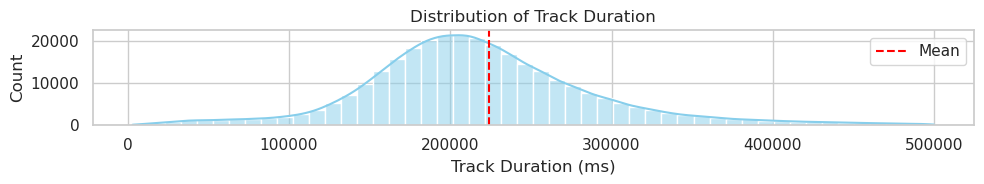

In [183]:
# AVG duration_ms
filtered_df = dashboard_df[dashboard_df["duration_ms"] < 500000]
duration_ms_AVG = round(dashboard_df["duration_ms"].mean(), 3)
print("AVG duration_ms:", duration_ms_AVG)

plt.figure(figsize=(10, 2))
sns.histplot(filtered_df["duration_ms"].dropna(), bins=50, kde=True, color="skyblue")
plt.axvline(duration_ms_AVG, color='red', linestyle='--', label='Mean')
plt.xlabel("Track Duration (ms)")
plt.title("Distribution of Track Duration")
plt.legend()
plt.tight_layout()
plt.show()

Only tracks with duration < 5 minutes are shown for visualization clarity. The red dashed line represents the true overall average (including outliers).

<h3> Total artists </h3>

In [184]:
total_artists = dashboard_df["artist_spotify_id"].nunique()
print("Total Artists", total_artists)

Total Artists 1958


<h3> Top Track </h3>

In [185]:
top_track = dashboard_df[["track_name", "popularity_track", "artist_name"]]
top_track = top_track.sort_values("popularity_track", ascending=False).head(1)
track_name = top_track.iloc[0]["track_name"]
artist_name = top_track.iloc[0]["artist_name"]
popularity = top_track.iloc[0]["popularity_track"]

print(f"🎵 Top Track: '{track_name}' by {artist_name} (Popularity: {popularity})")


🎵 Top Track: 'DtMF' by Bad Bunny (Popularity: 98)


<h3> Top Album </h3>

In [187]:
dashboard_df["release_date"] = pd.to_datetime(dashboard_df["release_date"], errors="coerce")

dashboard_df["year"] = dashboard_df["release_date"].dt.year
latest_years = sorted(dashboard_df["year"].dropna().unique())[-5:]
recent_df = dashboard_df[dashboard_df["year"].isin(latest_years)]

top_album_by_year = (
    recent_df.sort_values("popularity_album",ascending=False).groupby("year").first().reset_index()[["year", "album_name", "artist_name", "popularity_album"]]
)
# top_album = dashboard_df[["album_name","popularity_album","artist_name"]]
# top_album = top_album.sort_values("popularity_album",ascending=False).head(1)
# album_name = top_album.iloc[0]["album_name"]
# album_artist = top_album.iloc[0]["artist_name"]
# popularity_album = top_album.iloc[0]["popularity_album"]

print(top_album_by_year)

dashboard_df.drop(columns=["year"], inplace=True)


     year                   album_name     artist_name  popularity_album
0  2021.0  Dangerous: The Double Album   Morgan Wallen                83
1  2022.0             Un Verano Sin Ti       Bad Bunny                89
2  2023.0           $AD BOYZ 4 LIFE II        Junior H                86
3  2024.0                          GNX  Kendrick Lamar                93
4  2025.0         DeBÍ TiRAR MáS FOToS       Bad Bunny               100


<h3> genre total </h3>

In [188]:
all_genre = dashboard_df["genres"].str.split(",").explode().str.strip()

genre_counts = all_genre.value_counts().count()

print("Total genres:",genre_counts)


Total genres: 533


<h3> Calculate KPI: % Change in Number of Tracks by Year </h3>

In [189]:
dashboard_df["release_date"] = pd.to_datetime(dashboard_df["release_date"], errors="coerce")
dashboard_df["year"] = dashboard_df["release_date"].dt.year

track_by_year = (
    dashboard_df.groupby("year")["track_id"]
    .count()
    .reset_index(name="track_count")
)

track_by_year["pct_change"] = track_by_year["track_count"].pct_change() * 100
print(track_by_year.tail())
latest_year = track_by_year["year"].max()
latest_row = track_by_year[track_by_year["year"] == latest_year]

track_count_latest = int(latest_row["track_count"].values[0])
pct_change_latest = float(latest_row["pct_change"].values[0])

print(f"Track released in {latest_year}: {track_count_latest}")
print(f"Change from previous year: {pct_change_latest:.2f}%")



      year  track_count  pct_change
60  2021.0        20696   16.827547
61  2022.0        21410    3.449942
62  2023.0        25383   18.556749
63  2024.0        28517   12.346846
64  2025.0        10356  -63.684820
Track released in 2025.0: 10356
Change from previous year: -63.68%


In [190]:
genre_counts = all_genre.value_counts()


In [191]:
genre_counts_top10 = all_genre.value_counts().head(10)
genre_counts_top10

genres
banda              14975
norteño            12467
country            12341
classic rock       11779
corrido            11175
rock               11022
latin pop          10701
grupera             9314
reggaeton           9056
música mexicana     8715
Name: count, dtype: int64

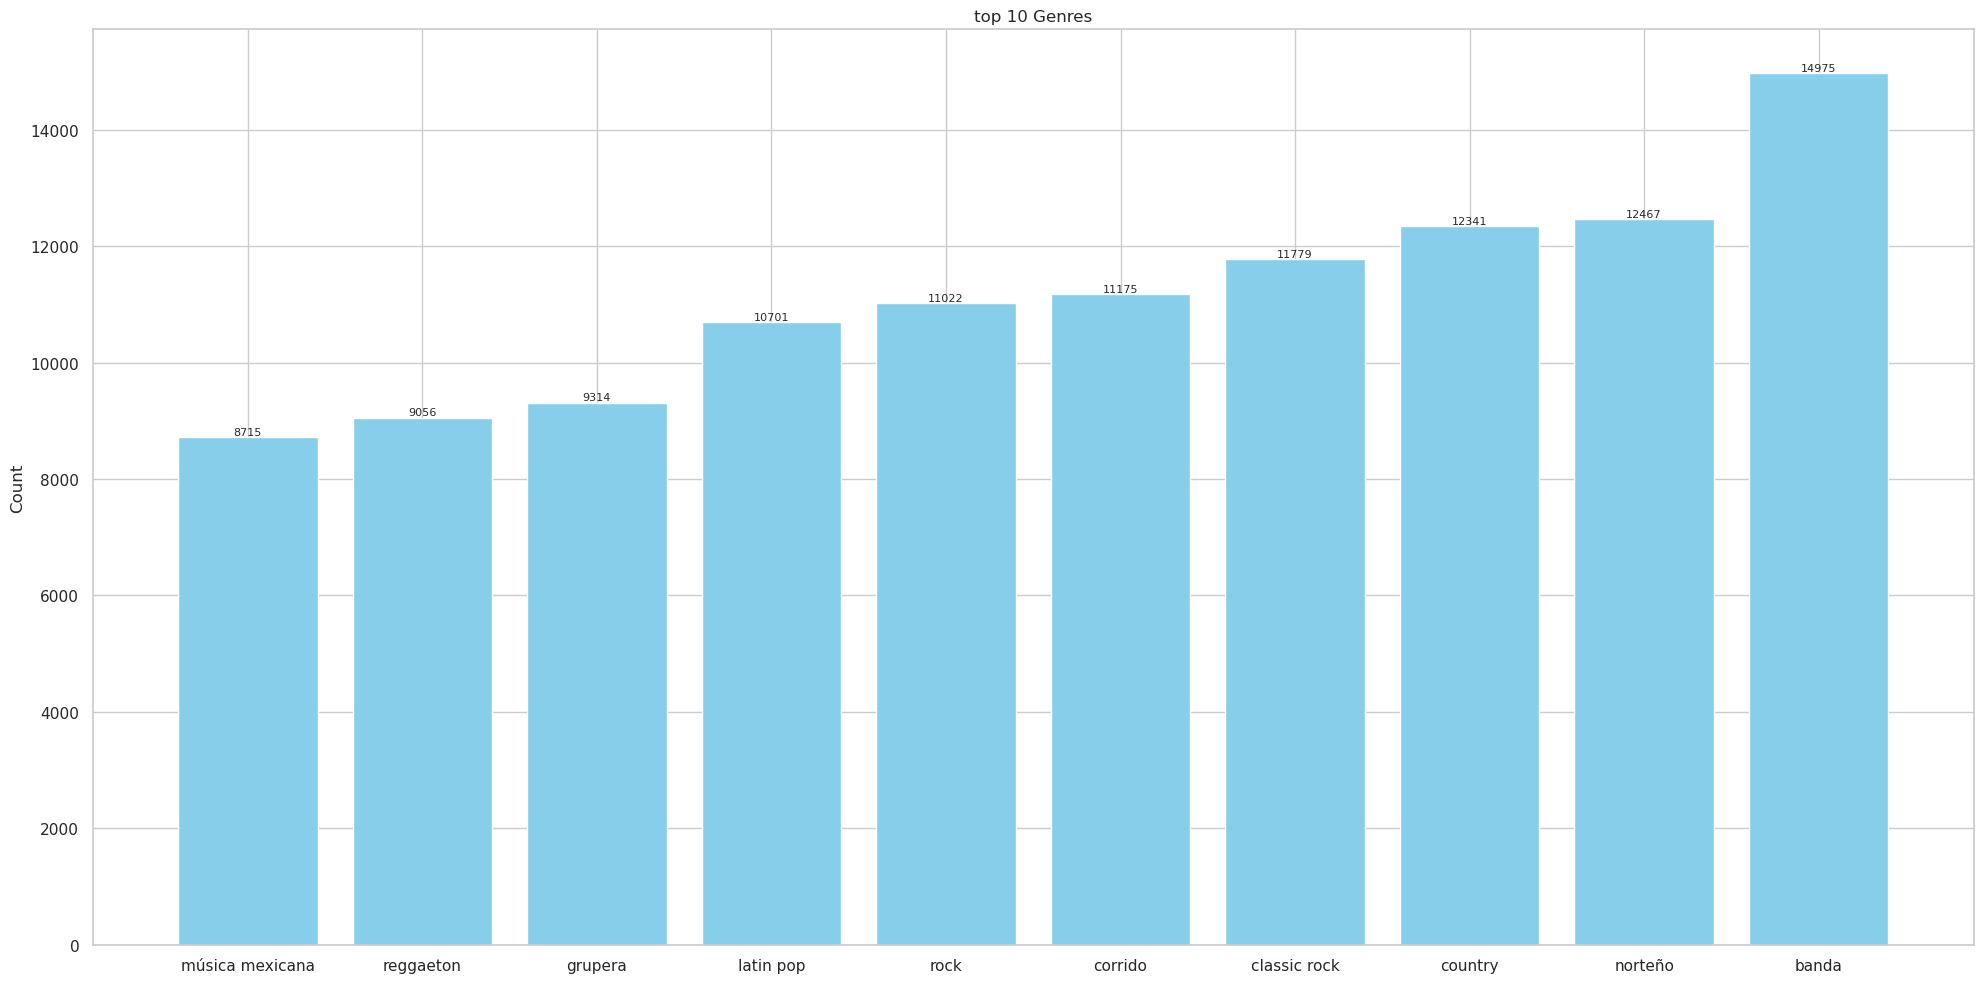

In [192]:
plt.figure(figsize=(20, 10))
bars = plt.bar(genre_counts_top10.index[::-1], genre_counts_top10.values[::-1], color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             str(int(height)),
             ha='center', va='bottom', fontsize=8)



plt.ylabel("Count")
plt.title("top 10 Genres")
plt.tight_layout()
plt.show()

<h1> Number of album per Year </h1>

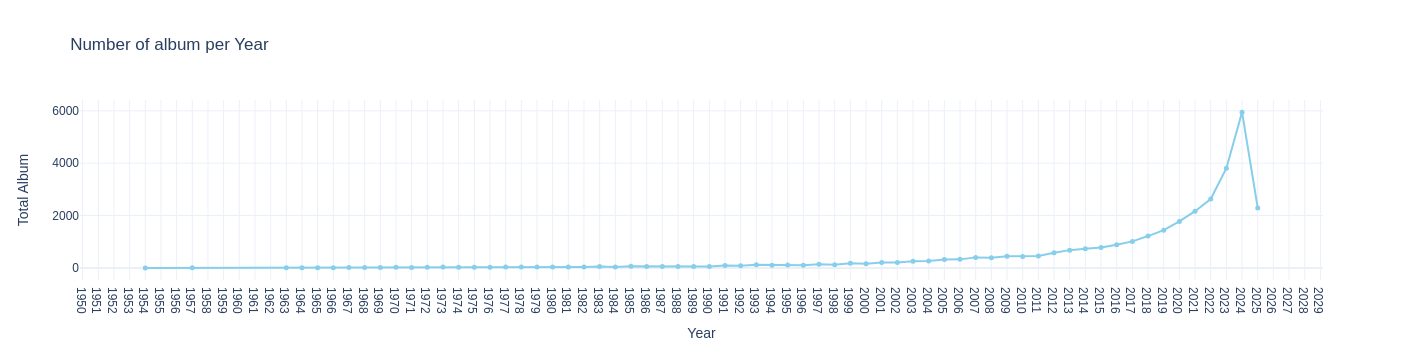

In [193]:
dashboard_df["release_date"] = pd.to_datetime(dashboard_df["release_date"], errors="coerce")
dashboard_df["year"] = dashboard_df["release_date"].dt.year

album_counts = dashboard_df.drop_duplicates(subset=["album_name", "year"]).groupby("year")["album_name"].count().reset_index()
album_counts.columns = ["year", "album_count"]

fig = px.line(album_counts, x="year", y="album_count", markers=True,
              title="Number of album per Year",
              labels={"year": "Year", "album_count": "Total Album"},
              hover_data={"year": True, "album_count": True})

fig.update_traces(line=dict(color="skyblue"), marker=dict(size=5))

fig.update_layout(
    hovermode="x unified",
    xaxis=dict(dtick=1),
    template="plotly_white"
)

fig.show()


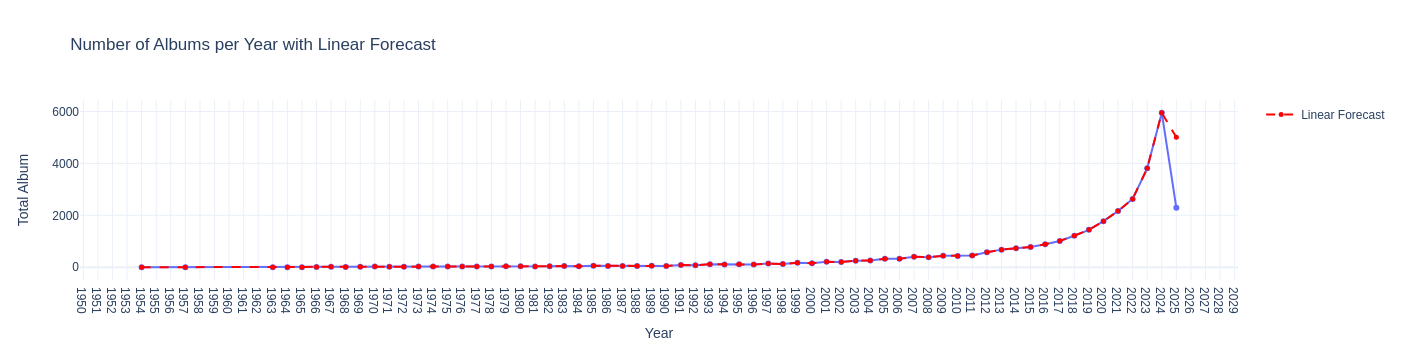

In [194]:
import plotly.express as px
from sklearn.linear_model import LinearRegression
import numpy as np

album_counts = dashboard_df.drop_duplicates(subset=["album_name", "year"]).groupby("year")["album_name"].count().reset_index()
album_counts.columns = ["year", "album_count"]
train_df = album_counts[(album_counts["year"] < 2025 )& (album_counts["year"] > 2015)]
X_train = train_df["year"].values.reshape(-1, 1)
y_train = train_df["album_count"].values
model = LinearRegression()
model.fit(X_train, y_train)
X_forecast = np.array([[2025]])
y_pred_2025 = model.predict(X_forecast)[0]
album_forecast_df = album_counts.copy()
if 2025 in album_forecast_df["year"].values:
    album_forecast_df.loc[album_forecast_df["year"] == 2025, "album_count"] = y_pred_2025
else:
    album_forecast_df = pd.concat([
        album_forecast_df,
        pd.DataFrame({"year": [2025], "album_count": [y_pred_2025]})
    ], ignore_index=True)
fig = px.line(album_counts, x="year", y="album_count", markers=True,
              title=" Number of Albums per Year with Linear Forecast",
              labels={"year": "Year", "album_count": "Total Album"},
              hover_data={"year": True, "album_count": True})
fig.add_scatter(x=album_forecast_df["year"], y=album_forecast_df["album_count"],
                mode="lines+markers",
                name="Linear Forecast",
                line=dict(color="red", dash="dash"),
                marker=dict(size=5))

fig.update_layout(
    hovermode="x unified",
    xaxis=dict(dtick=1),
    template="plotly_white"
)

fig.show()


In [195]:
dashboard_df["month"] = dashboard_df["release_date"].dt.month
df_2025 = dashboard_df[dashboard_df["year"]==2025]
df_2025["month"].nunique()

6

<h1> Pie chart for album type </h1>

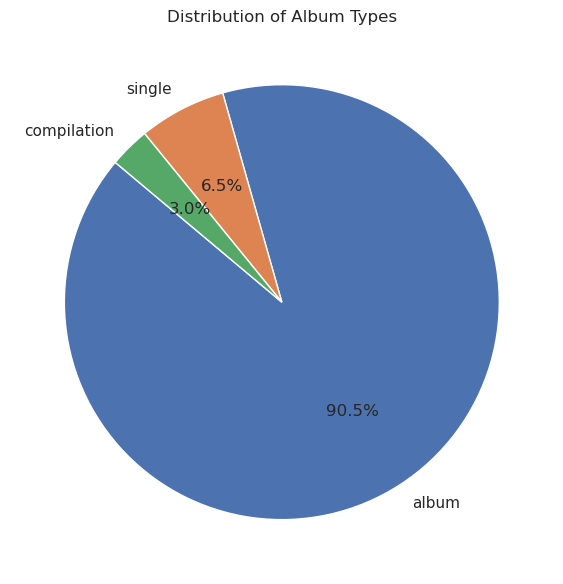

In [196]:
type_counts = dashboard_df["album_type"].value_counts()
plt.figure(figsize=(6, 6))

plt.pie(type_counts.values,labels=type_counts.index,autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Album Types")
plt.tight_layout()
plt.show()
       

<h1> Top 10 Artists with Most Followers </h1>

In [197]:
top_10_artists = (
    dashboard_df[["artist_name", "followers number"]]
    .dropna()
    .drop_duplicates(subset="artist_name")
    .sort_values("followers number", ascending=False)
    .head(10)
)

print(top_10_artists)


        artist_name  followers number
2757   Arijit Singh         141174367
352      Ed Sheeran         119755896
2941  Ariana Grande         104533955
600          Eminem          99037760
873           Drake          97311494
776       Bad Bunny          93140614
527             BTS          78407876
3042          Adele          63331380
569     A.R. Rahman          61467654
1131        KAROL G          55739134


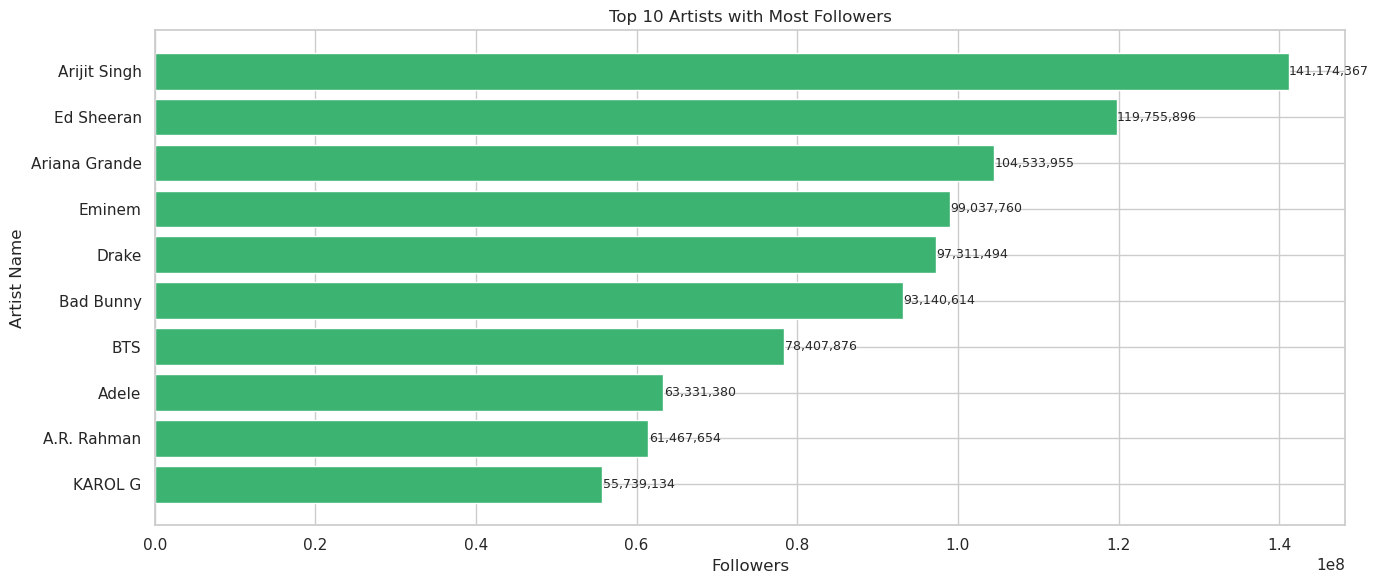

In [198]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

artists = top_10_artists["artist_name"][::-1]
followers = top_10_artists["followers number"][::-1]

bars = plt.barh(artists, followers, color='mediumseagreen')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 50000, bar.get_y() + bar.get_height()/2,
             f"{int(width):,}", va='center', fontsize=9)

plt.xlabel("Followers")
plt.ylabel("Artist Name")
plt.title("Top 10 Artists with Most Followers")
plt.tight_layout()
plt.show()


🔎 Pearson Correlation (speechiness vs acousticness): -0.66


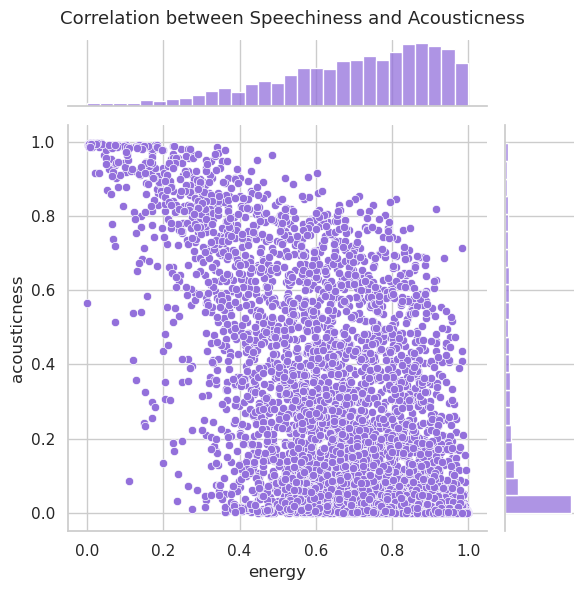

In [199]:

df_corr = dashboard_df[["energy", "acousticness"]].dropna()

corr = df_corr.corr().loc["energy", "acousticness"]
print(f"🔎 Pearson Correlation (speechiness vs acousticness): {corr:.2f}")

sns.set(style="whitegrid")

plot = sns.jointplot(
    data=df_corr,
    x="energy",
    y="acousticness",
    kind="scatter",
    color="mediumpurple",
    height=6,
    space=0.3
)

plot.fig.suptitle("Correlation between Speechiness and Acousticness", fontsize=13)
plot.fig.tight_layout()
plot.fig.subplots_adjust(top=0.93)

plt.show()


/tmp/ipykernel_1087/2019455507.py:20: UserWarning:

Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.



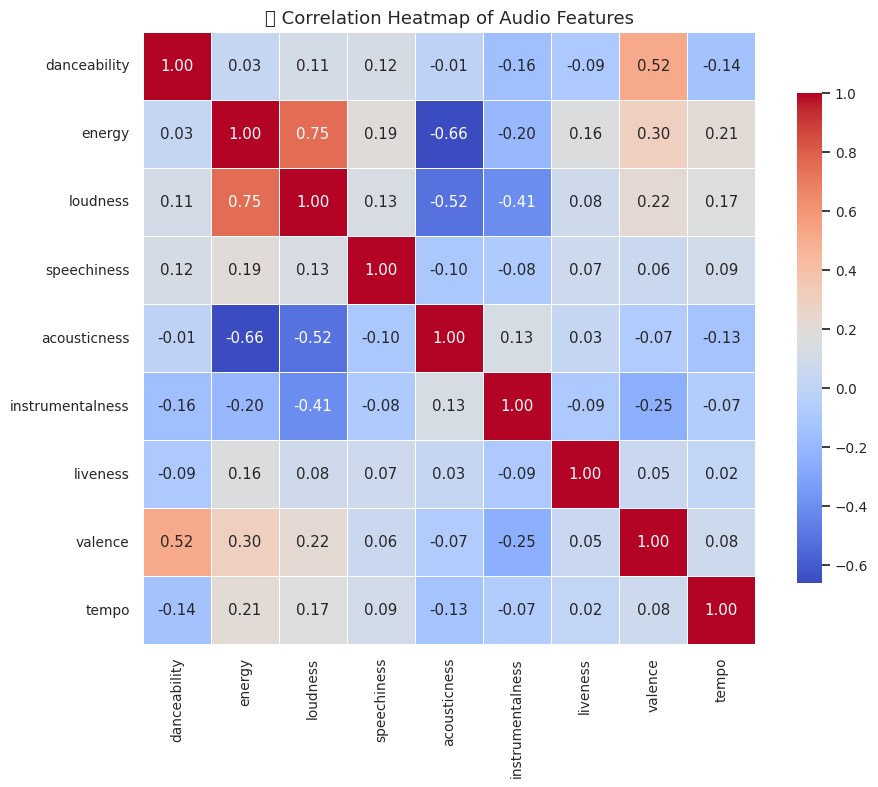

In [200]:
audio_features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]

df_audio = dashboard_df[audio_features].dropna()

# 2. Tính ma trận tương quan
corr_matrix = df_audio.corr()

# 3. Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=0.9)

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            linewidths=0.5, cbar_kws={"shrink": .8})

plt.title("🎵 Correlation Heatmap of Audio Features", fontsize=13)
plt.tight_layout()
plt.show()

<h1> Page Artist </h1>

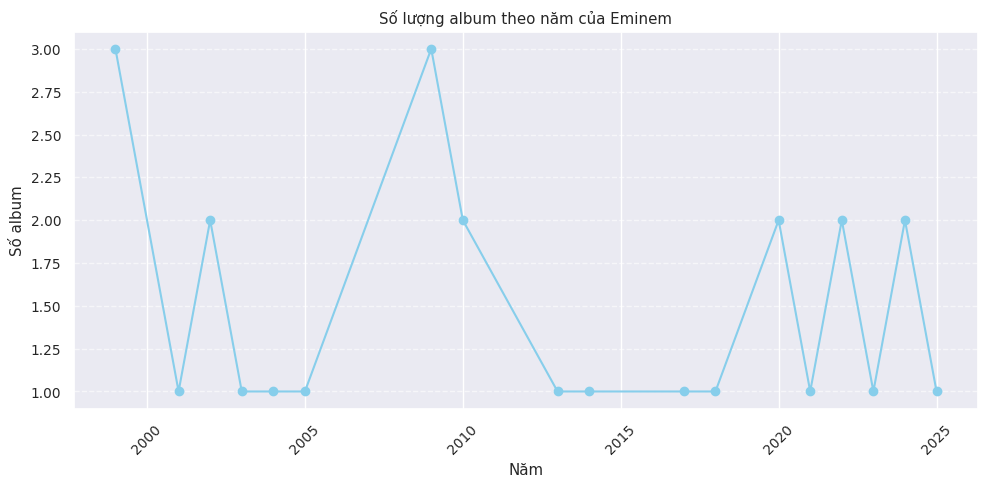

In [244]:
selected = "Eminem"

artist_df = dashboard_df[dashboard_df["artist_name"] == selected].copy()
album_counts = (
    artist_df.drop_duplicates(subset=["album_name", "year"])
    .groupby("year")["album_name"]
    .count()
    .reset_index()
)
plt.figure(figsize=(10, 5))
plt.plot(album_counts["year"], album_counts["album_name"], marker="o", color="skyblue")
plt.title(f"Số lượng album theo năm của {selected}")
plt.xlabel("Năm")
plt.ylabel("Số album")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1087/11622050.py:26: UserWarning:

Glyph 127911 (\N{HEADPHONE}) missing from current font.

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 127911 (\N{HEADPHONE}) missing from current font.



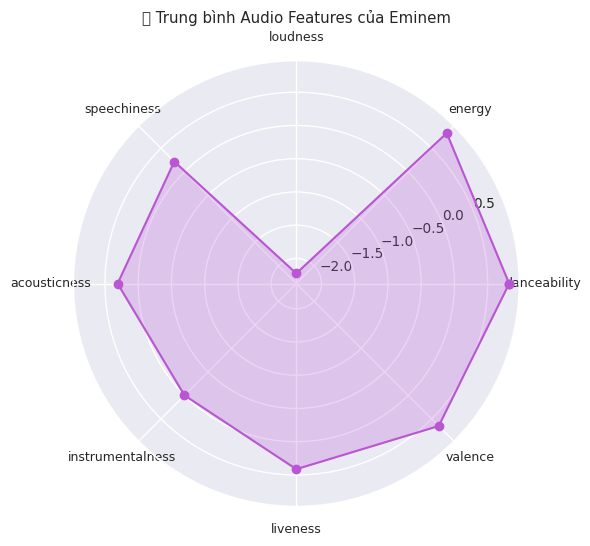

In [240]:

features = ["danceability", "energy", "loudness", "speechiness", "acousticness",
            "instrumentalness", "liveness", "valence"]

valid_features = []
valid_values = []

for feature in features:
    if artist_df[feature].notnull().any():
        mean_val = artist_df[feature].mean()
        valid_features.append(feature)
        valid_values.append(mean_val)

if not valid_features:
    print(f"{selected} không có đủ dữ liệu audio features.")
else:
    # Radar chart
    angles = np.linspace(0, 2 * np.pi, len(valid_features), endpoint=False).tolist()
    valid_values += valid_values[:1]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    plt.polar(angles, valid_values, marker='o', color='mediumorchid')
    plt.fill(angles, valid_values, alpha=0.25, color='mediumorchid')
    plt.xticks(angles[:-1], valid_features, fontsize=9)
    plt.title(f"Trung bình Audio Features của {selected}")
    plt.tight_layout()
    plt.show()


In [245]:
#KPI

- Tổng số track 
- Tổng số follower
- độ hot 
- phần trăm engery
- phần trăm liveness
- tổng instrucmentalness
- đem cái top 10 ở overview xuống thế trên overview bằng cái dưới

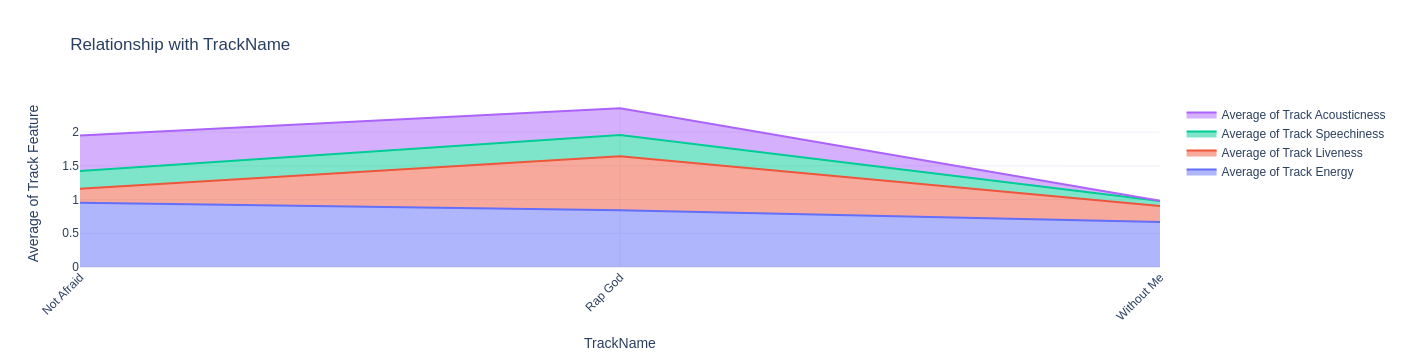

In [246]:
df_plot = artist_df[["track_name", "energy", "liveness", "speechiness", "acousticness"]].dropna().head(30)

fig = go.Figure()

for col in ["energy", "liveness", "speechiness", "acousticness"]:
    fig.add_trace(go.Scatter(
        x=df_plot["track_name"],
        y=df_plot[col],
        mode='lines',
        stackgroup='one',  # stack để tạo area chart
        name=f"Average of Track {col.capitalize()}"
    ))

fig.update_layout(
    title="Relationship with TrackName",
    xaxis_title="TrackName",
    yaxis_title="Average of Track Feature",
    xaxis_tickangle=-45,
    template="plotly_white"
)

fig.show()
